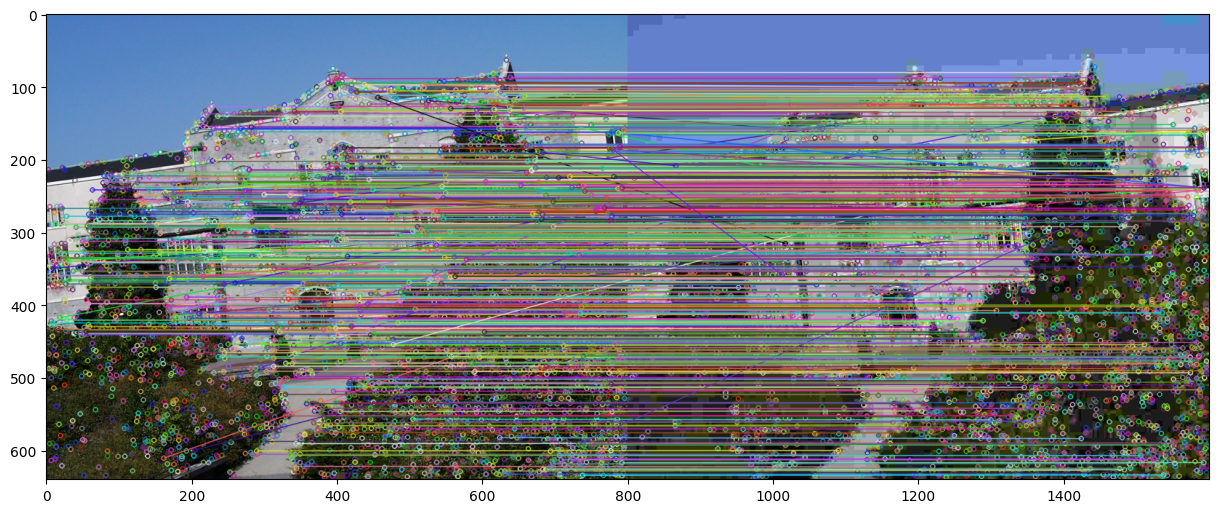

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the images
img1 = cv2.imread('pic/img1.ppm', cv2.IMREAD_COLOR)
img5 = cv2.imread('pic/img5.ppm', cv2.IMREAD_COLOR)

# Create a SIFT object
sift = cv2.SIFT_create()

# Find the keypoints and descriptors for both images
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints5, descriptors5 = sift.detectAndCompute(img5, None)

# Create a BFMatcher (Brute-Force Matcher) with default parameters
bf = cv2.BFMatcher()

# Match descriptors using KNN (k-nearest neighbors) with k=2
matches = bf.knnMatch(descriptors1, descriptors5, k=2)

# Apply ratio test to filter good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Draw the matches
matching_result = cv2.drawMatches(img1, keypoints1, img5, keypoints5, good_matches, None)

plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))



In [2]:
# Extract the matched keypoints
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints5[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Use RANSAC to estimate the homography matrix
homography_matrix, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Compare the computed homography with the one provided in the dataset
dataset_homography = np.array([[0.877, 0.479, 73.0], [-0.479, 0.877, 320.0], [0.0, 0.0, 1.0]])

# Print and compare the matrices
print("Computed Homography Matrix:")
print(homography_matrix)

print("\nDataset Homography Matrix:")
print(dataset_homography)

Computed Homography Matrix:
[[ 1.00099597e+00 -6.85431880e-04  3.13209320e-02]
 [ 3.54464572e-04  1.00014375e+00 -1.10532496e-01]
 [ 1.53690428e-06 -8.95294295e-07  1.00000000e+00]]

Dataset Homography Matrix:
[[  0.877   0.479  73.   ]
 [ -0.479   0.877 320.   ]
 [  0.      0.      1.   ]]


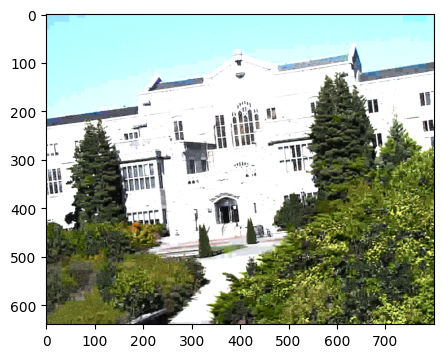

In [3]:
# Warp `img1.ppm` using the computed homography to align it with `img5.ppm`
stitched_image = cv2.warpPerspective(img1, homography_matrix, (img5.shape[1], img5.shape[0]))

# Overlay `img1.ppm` onto `img5.ppm`
result_image = cv2.addWeighted(stitched_image, 1, img5, 1, 0)

plt.figure(figsize=(5,5))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.show()
